<a href="https://colab.research.google.com/github/flaxoDS/CompletelyNew/blob/master/STIL10_customCNN_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from torchvision.datasets import STL10
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = STL10(root='./data', split='train', download=True, transform=transform)
test_data = STL10(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


100%|██████████| 2.64G/2.64G [04:33<00:00, 9.65MB/s]


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class STL10CNN(nn.Module):
    def __init__(self):
        super(STL10CNN, self).__init__()
        # Eingabe: (3, 96, 96)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   # → (16, 96, 96)
        self.pool = nn.MaxPool2d(2, 2)                            # → (16, 48, 48)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # → (32, 48, 48)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # → (64, 48, 48)
        self.pool2 = nn.MaxPool2d(2, 2)                           # → (64, 24, 24)

        self.fc1 = nn.Linear(64 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 Klassen

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))        # (16, 48, 48)
        x = F.relu(self.conv2(x))                   # (32, 48, 48)
        x = self.pool2(F.relu(self.conv3(x)))       # (64, 24, 24)
        x = x.view(-1, 64 * 24 * 24)                 # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
import torch.optim as optim

model = STL10CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training
for epoch in range(5):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 1.7745
Epoch 2, Loss: 1.3755
Epoch 3, Loss: 1.0929
Epoch 4, Loss: 0.8093
Epoch 5, Loss: 0.5300


In [5]:
model.eval()  # wichtig: Vorhersage-Modus aktivieren
correct = 0
total = 0

with torch.no_grad():  # keine Gradienten nötig
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 55.35%


In [6]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_grid(images, labels, preds=None, classes=None, nrow=5):
    images = images * 0.5 + 0.5  # Undo Normalize
    grid_img = vutils.make_grid(images[:nrow * nrow], nrow=nrow)

    plt.figure(figsize=(nrow * 2, nrow * 2))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title("STL-10 – Bilder mit Vorhersagen")
    plt.show()

    if preds is not None and classes is not None:
        for i in range(nrow * nrow):
            true = classes[labels[i]]
            pred = classes[preds[i]]
            mark = "✅" if labels[i] == preds[i] else "❌"
            print(f"{i+1:02d}. Label: {true:<8} | Prediction: {pred:<8} {mark}")


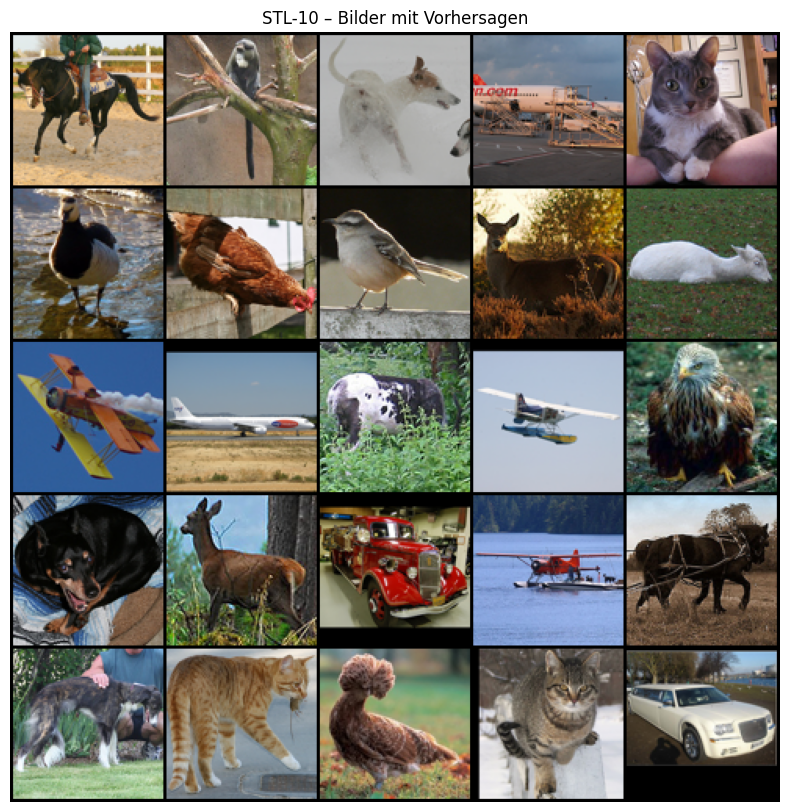

01. Label: horse    | Prediction: horse    ✅
02. Label: monkey   | Prediction: deer     ❌
03. Label: dog      | Prediction: bird     ❌
04. Label: airplane | Prediction: ship     ❌
05. Label: cat      | Prediction: cat      ✅
06. Label: bird     | Prediction: bird     ✅
07. Label: bird     | Prediction: dog      ❌
08. Label: bird     | Prediction: deer     ❌
09. Label: deer     | Prediction: deer     ✅
10. Label: deer     | Prediction: car      ❌
11. Label: airplane | Prediction: deer     ❌
12. Label: airplane | Prediction: airplane ✅
13. Label: deer     | Prediction: deer     ✅
14. Label: airplane | Prediction: airplane ✅
15. Label: bird     | Prediction: deer     ❌
16. Label: dog      | Prediction: horse    ❌
17. Label: deer     | Prediction: deer     ✅
18. Label: truck    | Prediction: car      ❌
19. Label: airplane | Prediction: airplane ✅
20. Label: horse    | Prediction: horse    ✅
21. Label: dog      | Prediction: horse    ❌
22. Label: cat      | Prediction: cat      ✅
23. Label:

In [7]:
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    show_grid(images.cpu(), labels.cpu(), preds.cpu(), classes=classes, nrow=5)


In [8]:
from torchvision import models

# ResNet18 vortrainiert laden
resnet18 = models.resnet18(pretrained=True)  # oder: weights="IMAGENET1K_V1" (neuere Schreibweise)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


In [9]:
import torch.nn as nn
from torchvision import models

# Vortrainiertes ResNet18 laden
resnet18 = models.resnet18(pretrained=True)

# Alle Gewichte einfrieren (Feature Extraction!)
for param in resnet18.parameters():
    param.requires_grad = False

# Letzte Schicht ersetzen: 512 → 10 Klassen für STL-10
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 10)



In [10]:
import torch.optim as optim

# Modell auf GPU/CPU schicken
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

# Nur die Parameter des neuen Klassifikators werden trainiert
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training
for epoch in range(5):
    resnet18.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 1.3392
Epoch 2, Loss: 0.7653
Epoch 3, Loss: 0.6523
Epoch 4, Loss: 0.5844
Epoch 5, Loss: 0.5446


In [11]:
resnet18.eval()  # Evaluierungsmodus aktivieren
correct = 0
total = 0

with torch.no_grad():  # keine Gradientenberechnung nötig
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"ResNet18 (Feature Extraction) Test Accuracy: {accuracy:.2f}%")


ResNet18 (Feature Extraction) Test Accuracy: 77.56%


In [12]:
from torchvision import models
import torch.nn as nn

resnet18 = models.resnet18(pretrained=True)

# Keine Layer einfrieren → Fine-Tuning!
# (alternativ: bestimmte Layer einfrieren – z. B. nur early layers)
for param in resnet18.parameters():
    param.requires_grad = True

# Klassifikator auf 10 Klassen anpassen
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 10)


In [13]:
import torch.optim as optim

# Jetzt alle Parameter trainieren – nicht nur resnet18.fc
optimizer = optim.Adam(resnet18.parameters(), lr=0.0001)  # kleinere Lernrate empfohlen


In [14]:
resnet18.to(device)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(5):
    resnet18.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[Fine-Tuning] Epoch {epoch+1}, Loss: {avg_loss:.4f}")


[Fine-Tuning] Epoch 1, Loss: 0.7991
[Fine-Tuning] Epoch 2, Loss: 0.1561
[Fine-Tuning] Epoch 3, Loss: 0.0530
[Fine-Tuning] Epoch 4, Loss: 0.0376
[Fine-Tuning] Epoch 5, Loss: 0.0418


In [15]:
resnet18.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"[Fine-Tuned ResNet18] Test Accuracy: {accuracy:.2f}%")


[Fine-Tuned ResNet18] Test Accuracy: 88.85%
